# EXPLORATORY DATA ANALYSIS

# Exploratory Data Analysis: TP53 Expression Matrices (Gambardella & Kinker)

This notebook performs EDA and prepares the data for multiclass classification of TP53 mutation status.

**Files:**
- `output/expression_matrix_with_tp53_status_gambardella.csv`
- `output/expression_matrix_with_tp53_status_kinker.csv`

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import mygene

## Load the Data Header and Gene Manipulation

In [ ]:
# Load only the headers of the Gambardella and Kinker expression matrices to inspect their structure
gambardella_path = '../output/expression_matrix_with_tp53_status_gambardella.csv'
kinker_path = '../output/expression_matrix_with_tp53_status_kinker.csv'


# Read only the headers
gambardella_header = pd.read_csv(gambardella_path, index_col=0, nrows=0)
kinker_header = pd.read_csv(kinker_path, index_col=0, nrows=0)

print(f'Gambardella columns: {len(gambardella_header.columns)}')
print(f'Kinker columns: {len(kinker_header.columns)}')

# Show first 5 columns for each
print('Gambardella first 5 columns:', list(gambardella_header.columns[:5]))
print('Kinker first 5 columns:', list(kinker_header.columns[:5]))

# Show last 5 columns for each
print('Gambardella last 5 columns:', list(gambardella_header.columns[-5:]))
print('Kinker last 5 columns:', list(kinker_header.columns[-5:]))

Gambardella columns: 47098
Kinker columns: 999
Gambardella first 5 columns: ['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000001036']
Kinker first 5 columns: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']
Gambardella last 5 columns: ['ENSG00000283420', 'ENSG00000284003', 'ENSG00000284685', 'Cell_line', 'TP53_status']
Kinker last 5 columns: ['AC067968.3', 'AC067969.1', 'AC067969.2', 'AC068057.1', 'Cell_line']


In [28]:
#Map Ensembl gene IDs in Gambardella columns to gene symbols using mygene, and rename columns accordingly
mg = mygene.MyGeneInfo()
ensembl_ids = [col for col in gambardella_header.columns if col.startswith('ENSG')]
# Query mygene for gene symbols
query = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
# Build mapping dictionary
id_to_symbol = {item['query']: item.get('symbol', None) for item in query if 'symbol' in item}
# Rename columns in Gambardella dataframe
gambardella_header_renamed = gambardella_header.rename(columns=id_to_symbol)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
930 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


## Target Gene Inspection

In [ ]:
# Load TP53 target genes and find their intersection with gene columns in Kinker and Gambardella datasets

# Load TP53 target genes from Excel file
target_genes_df = pd.read_excel('../data/TP53target/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')

# Use the "Gene Symbol" column for target genes
target_genes = set(target_genes_df["Gene Symbol"].astype(str).str.upper())

# Get gene columns from Kinker and Gambardella (excluding metadata columns)
exclude_cols = ['Cell_line', 'TP53_status']
kinker_genes = set([col.upper() for col in kinker_header.columns if col not in exclude_cols])
gambardella_genes = set([col.upper() for col in gambardella_header_renamed.columns if col not in exclude_cols])

# Find intersection with target genes
kinker_targets = target_genes & kinker_genes
gambardella_targets = target_genes & gambardella_genes

print(f"Number of TP53 target genes in Kinker: {len(kinker_targets)}")
print(f"Number of TP53 target genes in Gambardella: {len(gambardella_targets)}")
print(f"Example in Kinker: {list(kinker_targets)[:10]}")
print(f"Example in Gambardella: {list(gambardella_targets)[:10]}")

Number of TP53 target genes in Kinker: 2
Number of TP53 target genes in Gambardella: 337
Example in Kinker: ['ABCA12', 'ABCB1']
Example in Gambardella: ['CYFIP2', 'ACAD11', 'TGM2', 'CAV1', 'TBXAS1', 'CDC25C', 'BID', 'STAG1', 'GBP1', 'S100A2']


In [33]:
target_genes_df = pd.read_excel('../data/TP53target/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
target_genes_df["Gene Symbol"]
#tab1_ensembl_ids = [gene for gene in tab1["Ensembl ID"] if gene in df.columns]


0      ABCA12
1       ABCB1
2         NaN
3      ACAD11
4       ACTA2
        ...  
395     YPEL3
396     YWHAG
397     ZFP36
398     ZMAT3
399     ZNF79
Name: Gene Symbol, Length: 400, dtype: object

## 2. Compare Columns (Genes/Features)

Let's see the overlap and differences between the two datasets' columns.

In [8]:
gambardella_cols = set(gambardella_header.columns)
kinker_cols = set(kinker_header.columns)

# Exclude TP53 status column for gene comparison
tp53_col_candidates = [col for col in gambardella_cols.union(kinker_cols) if 'tp53' in col.lower() and 'status' in col.lower()]
print('Possible TP53 status columns:', tp53_col_candidates)

gene_cols_gambardella = gambardella_cols - set(tp53_col_candidates)
gene_cols_kinker = kinker_cols - set(tp53_col_candidates)

shared_genes = gene_cols_gambardella & gene_cols_kinker
unique_gambardella = gene_cols_gambardella - gene_cols_kinker
unique_kinker = gene_cols_kinker - gene_cols_gambardella

print(f'Shared genes: {len(shared_genes)}')
print(f'Unique to Gambardella: {len(unique_gambardella)}')
print(f'Unique to Kinker: {len(unique_kinker)}')

Possible TP53 status columns: ['TP53_status']
Shared genes: 1
Unique to Gambardella: 47097
Unique to Kinker: 999


## 3. Visualize Gene Overlap

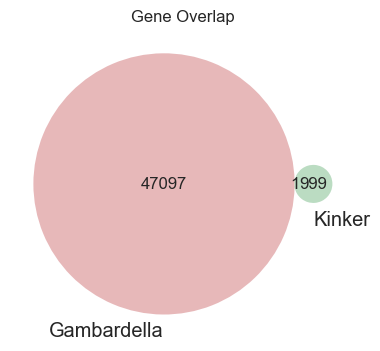

In [11]:
# If not installed: !pip install matplotlib-venn
from matplotlib_venn import venn2
plt.figure(figsize=(6,4))
venn2([gene_cols_gambardella, gene_cols_kinker], set_labels=('Gambardella', 'Kinker'))
plt.title('Gene Overlap')
plt.show()

## 4. Sample Data and Check TP53 Status Encoding

In [13]:
# Read a small sample from each file
sample_gambardella = pd.read_csv(gambardella_path, nrows=100)
sample_kinker = pd.read_csv(kinker_path, nrows=100)

# Check TP53 status column values
for col in tp53_col_candidates:
    if col in sample_gambardella.columns:
        print(f'Gambardella TP53 status ({col}):', sample_gambardella[col].value_counts())
    if col in sample_kinker.columns:
        print(f'Kinker TP53 status ({col}):', sample_kinker[col].value_counts())

Gambardella TP53 status (TP53_status): TP53_status
Missense_Mutation    100
Name: count, dtype: int64
Kinker TP53 status (TP53_status): TP53_status
Missense_Mutation    65
Nonsense_Mutation    21
Frame_Shift_Ins      11
Splice_Region         3
Name: count, dtype: int64


## 5. Basic EDA: Class Balance, Missing Data, Value Distributions

In [14]:
# Class balance
for name, sample in [('Gambardella', sample_gambardella), ('Kinker', sample_kinker)]:
    for col in tp53_col_candidates:
        if col in sample.columns:
            print(f'{name} TP53 status ({col}) class balance:')
            print(sample[col].value_counts(normalize=True))

Gambardella TP53 status (TP53_status) class balance:
TP53_status
Missense_Mutation    1.0
Name: proportion, dtype: float64
Kinker TP53 status (TP53_status) class balance:
TP53_status
Missense_Mutation    0.65
Nonsense_Mutation    0.21
Frame_Shift_Ins      0.11
Splice_Region        0.03
Name: proportion, dtype: float64


In [15]:
print('Gambardella missing values (sample):')
print(sample_gambardella.isnull().sum().sort_values(ascending=False).head())
print('Kinker missing values (sample):')
print(sample_kinker.isnull().sum().sort_values(ascending=False).head())

Gambardella missing values (sample):
Unnamed: 0         0
ENSG00000268416    0
ENSG00000178235    0
ENSG00000144031    0
ENSG00000200558    0
dtype: int64
Kinker missing values (sample):
Cell_ID       0
AC010761.9    0
AC010731.3    0
AC010731.4    0
AC010744.1    0
dtype: int64


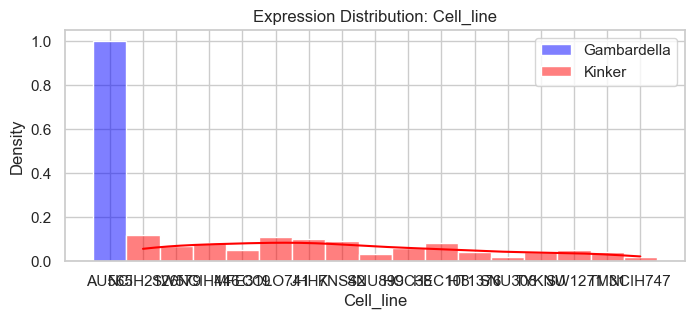

In [16]:
import random
random_genes = random.sample(list(shared_genes), min(5, len(shared_genes)))
for gene in random_genes:
    if gene in sample_gambardella.columns and gene in sample_kinker.columns:
        plt.figure(figsize=(8,3))
        sns.histplot(sample_gambardella[gene], color='blue', label='Gambardella', kde=True, stat='density', bins=30, alpha=0.5)
        sns.histplot(sample_kinker[gene], color='red', label='Kinker', kde=True, stat='density', bins=30, alpha=0.5)
        plt.title(f'Expression Distribution: {gene}')
        plt.legend()
        plt.show()

## 6. Prepare for Merging

- Use only shared genes.
- Add a 'dataset' column to each.

In [17]:
# Example: How to merge (on shared genes + TP53 status)
# This is a template for later, not run on full data yet due to size
def prepare_for_merge(df, dataset_name, shared_genes, tp53_col):
    cols = list(shared_genes) + [tp53_col]
    df = df[cols].copy()
    df['dataset'] = dataset_name
    return df

# Example usage on sample
# merged_sample = pd.concat([
#     prepare_for_merge(sample_gambardella, 'gambardella', shared_genes, tp53_col_candidates[0]),
#     prepare_for_merge(sample_kinker, 'kinker', shared_genes, tp53_col_candidates[0])
# ], ignore_index=True)

---

**Next steps:**
- If all looks good, proceed to merge the full datasets on shared genes.
- Consider batch effect visualization and correction before modeling.